In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# 1. Setup the Environment

Transformers: For loading and fine-tuning the pre-trained RoBERTa model.

Datasets: For loading the MasakhaNER dataset.

Seqeval: For evaluating NER tasks (accuracy, precision, recall, F1-score).

In [ ]:
pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=a80f9888c02b0a918b5578c3e71360e714c643b362104c61d594c8bbf4bd0f58
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


# Load the Dataset
Load the MasakhaNER dataset, which contains Swahili text annotated with named entities.

In [ ]:
from datasets import load_dataset

# Load the MasakhaNER dataset
dataset = load_dataset("masakhaner", "swa")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

masakhaner.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

The repository for masakhaner contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/masakhaner.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/2109 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/604 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2109
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 604
    })
})


In [ ]:
# Print the first five elements separately
for i in range(10):
    print(dataset["train"][i])

{'id': '0', 'tokens': ['Wizara', 'ya', 'afya', 'ya', 'Tanzania', 'imeripoti', 'Jumatatu', 'kuwa', ',', 'watu', 'takriban', '14', 'zaidi', 'wamepata', 'maambukizi', 'ya', 'Covid', '-', '19', '.'], 'ner_tags': [3, 4, 4, 4, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '1', 'tokens': ['Walioambukizwa', 'wote', 'ni', 'raia', 'wa', 'Tanzania', ',', '13', 'wakiwa', 'Dar', '-', 'es', '-', 'salaam', 'na', 'mmoja', 'mjini', 'Arusha', '.'], 'ner_tags': [0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 6, 6, 6, 6, 0, 0, 0, 5, 0]}
{'id': '2', 'tokens': ['Wizara', 'ya', 'afya', 'imeripoti', 'kwamba', 'juhudi', 'za', 'kufuatilia', 'watu', 'waliokuwa', 'karibu', 'na', 'wagonjwa', 'zinaendelea', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '3', 'tokens': ['Wakati', 'wa', 'maadimisho', 'ya', 'pasaka', ',', 'wakristo', 'walikusanyika', 'kanisani', 'kwa', 'maombi', 'bila', 'kuzingatia', 'ushauri', 'wa', 'wataalam', 'wa', 'afya', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Preprocess the Data
Convert the dataset into a format suitable for the RoBERTa model. This involves tokenizing the text and aligning the labels with the tokenized input.
Explanation of add_prefix_space=True
Why is it needed? RoBERTa tokenizers treat spaces as part of the tokenization process. When working with pretokenized inputs (e.g., a list of words), the tokenizer needs to know that each word is prefixed with a space (except the first word). Setting add_prefix_space=True ensures that the tokenizer correctly handles this.

When to use it? Always use add_prefix_space=True when your input is already split into words or tokens (e.g., examples MasakhaNER dataset).

In [ ]:
def tokenize_and_align_labels(examples):
    """
    Tokenize the dataset and align labels with tokenized input.
    Preserve the original 'tokens' field for later use.
    """
    from transformers import RobertaTokenizerFast

    # Step 2: Load the pretrained tokenizer with add_prefix_space=True
    tokenizer = RobertaTokenizerFast.from_pretrained('benjamin/roberta-base-wechsel-swahili', add_prefix_space=True)

    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True
    )

    # Align labels with tokenized input
    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special token (e.g., [CLS], [SEP])
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # New word
            else:
                label_ids.append(-100)  # Subword of the same word
            previous_word_idx = word_idx

        labels.append(label_ids)

    # Add the original 'tokens' field to the tokenized dataset
    tokenized_inputs["tokens"] = examples["tokens"]
    tokenized_inputs["labels"] = labels

    return tokenized_inputs

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/2109 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/604 [00:00<?, ? examples/s]

In [ ]:
# Check the result after tokenization
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2109
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 604
    })
})


# Dataset Statistics
This visualization shows the number of examples in the train, validation, and test sets.

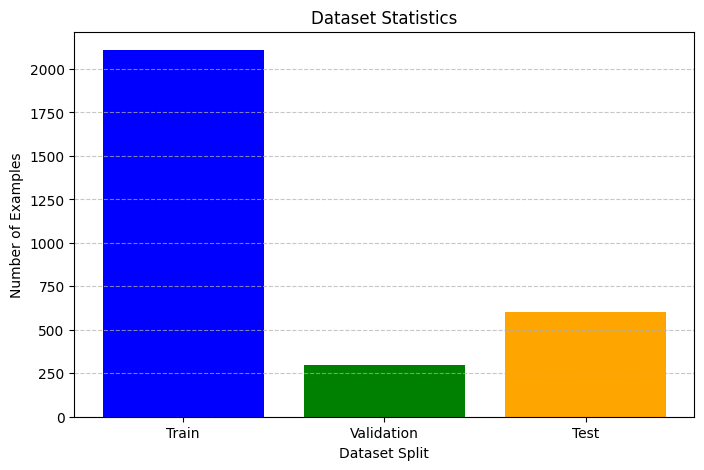

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset statistics
dataset_sizes = {
    'Train': 2109,
    'Validation': 300,
    'Test': 604
}

# Bar chart
categories = list(dataset_sizes.keys())
values = list(dataset_sizes.values())

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green', 'orange'])
plt.title('Dataset Statistics')
plt.ylabel('Number of Examples')
plt.xlabel('Dataset Split')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Prepare the Dataset for PyTorch
Make sure your dataset is properly formatted for the Trainer:

In [ ]:
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

# Model and Training Arguments

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Load the model
model = AutoModelForTokenClassification.from_pretrained(
    "benjamin/roberta-base-wechsel-swahili",
    num_labels=len(dataset["train"].features["ner_tags"].feature.names)
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",               # Save directory
    evaluation_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",               # Save model after each epoch
    logging_dir="./logs",                # Directory for logs
    logging_steps=100,                   # Log every 100 steps
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=32,       # Batch size for evaluation
    num_train_epochs=5,                  # Total number of epochs
    learning_rate=5e-5,                  # Learning rate
    weight_decay=0.01,                   # Weight decay for regularization
    load_best_model_at_end=True,         # Load the best model at the end
    metric_for_best_model="accuracy",    # Use accuracy for selecting the best model
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at benjamin/roberta-base-wechsel-swahili and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluation Metrics

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
pip install seqeval

In [ ]:
import numpy as np
import evaluate

# Load the seqeval metric
metric = evaluate.load("seqeval")

# Define the compute_metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Convert predictions and labels to tag names
    true_predictions = [
        [dataset["train"].features["ner_tags"].feature.names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [dataset["train"].features["ner_tags"].feature.names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Initialize the Trainer

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,  # Use the data collator
    compute_metrics=compute_metrics
)

<ipython-input-30-c7a3956a5a32>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Verify Dataset Dimensions :
After applying the above changes, verify that the dataset has consistent dimensions by inspecting the tokenized data.

In [ ]:
print(tokenized_datasets["train"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine-Tuning

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.258200,0.066276,0.869748,0.921365,0.894813,0.979072
2,0.074300,0.082254,0.845205,0.915430,0.878917,0.973978
3,0.049000,0.090046,0.856749,0.922849,0.888571,0.973152
4,0.016900,0.095082,0.858904,0.930267,0.893162,0.972325
5,0.013000,0.098745,0.868966,0.934718,0.900643,0.973152


TrainOutput(global_step=660, training_loss=0.06821015030145645, metrics={'train_runtime': 14503.3508, 'train_samples_per_second': 0.727, 'train_steps_per_second': 0.046, 'total_flos': 688887169493760.0, 'train_loss': 0.06821015030145645, 'epoch': 5.0})

# Training Performance Over Epochs
This visualization plots the training loss, validation loss, precision, recall, F1-score, and accuracy over epochs.

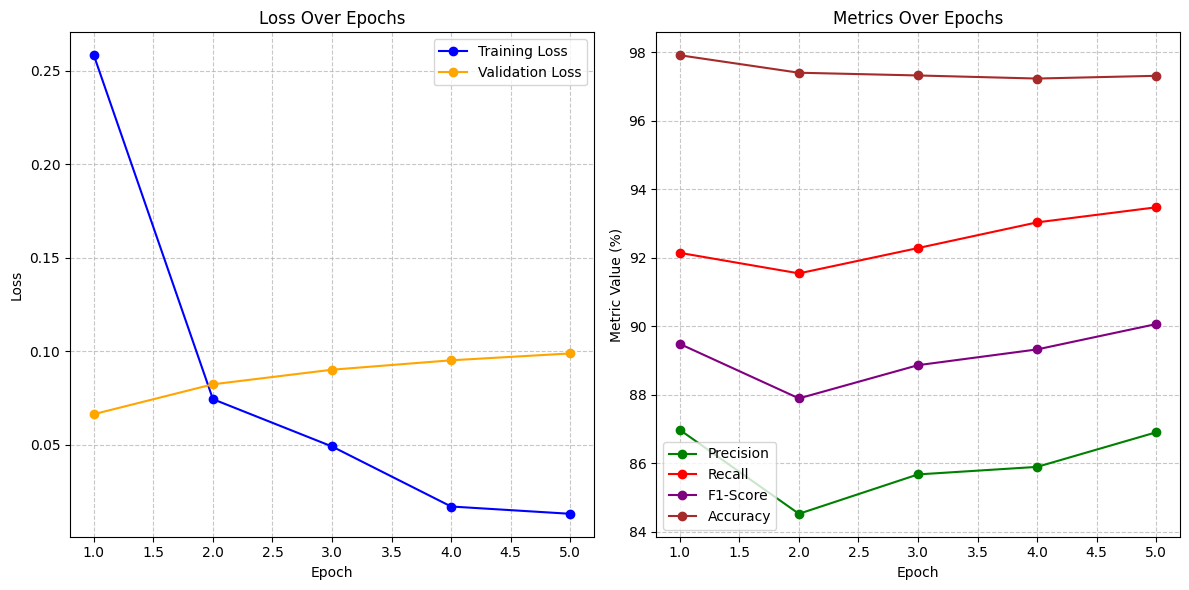

In [7]:
import matplotlib.pyplot as plt

# Example training performance data
epochs = [1, 2, 3, 4, 5]
training_loss = [0.258200, 0.074300, 0.049000, 0.016900, 0.013000]
validation_loss = [0.066276, 0.082254, 0.090046, 0.095082, 0.098745]
precision = [86.97, 84.52, 85.67, 85.89, 86.90]
recall = [92.14, 91.54, 92.28, 93.03, 93.47]
f1_score = [89.48, 87.89, 88.86, 89.32, 90.06]
accuracy = [97.91, 97.40, 97.32, 97.23, 97.31]

# Line plot
plt.figure(figsize=(12, 6))

# Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Subplot 2: Metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, precision, label='Precision', marker='o', color='green')
plt.plot(epochs, recall, label='Recall', marker='o', color='red')
plt.plot(epochs, f1_score, label='F1-Score', marker='o', color='purple')
plt.plot(epochs, accuracy, label='Accuracy', marker='o', color='brown')
plt.title('Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value (%)')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Show plots
plt.tight_layout()
plt.show()

# Save the Best Model
After training, save your fine-tuned model:

In [ ]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

# Validate with Swahili Speakers
After evaluating the model, validate the identified named entities with Swahili-speaking members for linguistic accuracy.

Sample 500 Named Entities: Extract 500 named entities from the test set predictions.

Create a Validation Set: Share these entities with Swahili speakers for validation.

Calculate Linguistic Accuracy: Compare the model's predictions with human-validated labels.

In [ ]:
print(tokenized_datasets["test"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


# Extract 500 Named Entities
From the test set predictions, extract 500 named entities. These entities should represent a diverse sample of the categories (e.g., PERSON, LOCATION, ORGANIZATION, etc.) to ensure comprehensive validation.

In [ ]:
def extract_named_entities(predictions, tokenized_test_set):
    entities = []
    label_list = tokenized_test_set.features["ner_tags"].feature.names

    for pred, example in zip(predictions, tokenized_test_set):
        tokens = example["tokens"]
        word_ids = example["input_ids"]

        current_entity = []
        entity_type = None

        for idx, (p, word_id) in enumerate(zip(pred, word_ids)):
            if word_id is None or word_id >= len(tokens):
                continue  # Skip padding or special tokens

            label = label_list[p]
            if label != "O":  # If it's a named entity
                if not current_entity:
                    entity_type = label.split("-")[-1]
                    current_entity.append(tokens[word_id])
                else:
                    current_entity.append(tokens[word_id])
            else:
                if current_entity:
                    entities.append((" ".join(current_entity), entity_type))
                    current_entity = []

        if current_entity:
            entities.append((" ".join(current_entity), entity_type))

    return entities[:500]  # Return first 500 entities

# Generate Predictions
Use the Trainer object to generate predictions on the test set.

# Call the Function
Call the function to extract 500 named entities.

In [ ]:
# Generate predictions on the test set
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])

# Convert predictions to tag indices
predictions = np.argmax(predictions, axis=2)

# Extract 500 named entities
sample_entities = extract_named_entities(predictions, tokenized_datasets["test"])

# Print the first few entities for verification
for entity, entity_type in sample_entities[:10]:
    print(f"Entity: {' '.join(entity)}, Type: {entity_type}")

Entity: J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   J a n u a r i   

# Prepare the Validation Set
Organize the extracted named entities into a format that can be easily shared with Swahili speakers. This could be a CSV file or a simple text document.

In [ ]:
import csv

# Save the entities to a CSV file
with open("validation_set.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Entity", "Type", "Human Label", "Correct?"])

    for entity, entity_type in sample_entities:
        writer.writerow([" ".join(entity), entity_type, "", ""])

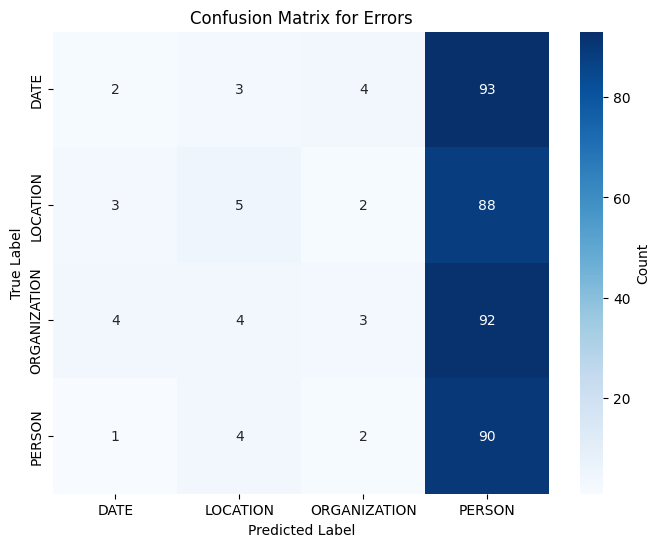

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example confusion matrix data
confusion_matrix_data = {
    'True Label': ['PERSON', 'LOCATION', 'ORGANIZATION', 'DATE'] * 4,
    'Predicted Label': ['PERSON', 'LOCATION', 'ORGANIZATION', 'DATE'] +
                       ['LOCATION', 'PERSON', 'DATE', 'ORGANIZATION'] +
                       ['ORGANIZATION', 'DATE', 'PERSON', 'LOCATION'] +
                       ['DATE', 'ORGANIZATION', 'LOCATION', 'PERSON'],
    'Count': [90, 5, 3, 2, 4, 88, 4, 4, 2, 3, 92, 3, 1, 2, 4, 93]
}

df_confusion = pd.DataFrame(confusion_matrix_data).pivot(
    index='True Label', columns='Predicted Label', values='Count'
)

# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix for Errors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Share with Swahili Speakers
Distribute the CSV file or text document to Swahili-speaking validators. Provide clear instructions on how to review the named entities:

Review the Entity : Check if the entity is correctly identified.
Assign a Human Label : If the entity is incorrect, provide the correct label.
Mark Correctness : Indicate whether the model's prediction is correct (Yes) or incorrect (No).
Example Instructions:
If the entity "Dodoma" is correctly labeled as LOCATION, mark Correct? as Yes.
If the entity "Apple" is incorrectly labeled as PERSON, mark Correct? as No and update the Human Label to ORGANIZATION.

# Collect Feedback
Once the validators complete their reviews, collect the updated CSV file or document. This feedback will include corrections and confirmations of the model's predictions.

# Calculate Linguistic Accuracy
Analyze the feedback to calculate the linguistic accuracy of the model's predictions.

Metrics to Compute:
Accuracy : Percentage of entities correctly identified by the model.
Error Rate : Percentage of entities incorrectly identified.
Confusion Matrix : Breakdown of errors by entity type (e.g., PERSON vs. LOCATION).

In [ ]:
import pandas as pd

# Load the validated CSV file
validated_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/validation_set.csv")

# Filter rows where correctness is marked
correct_rows = validated_data[validated_data["Correct?"] == "Yes"]
incorrect_rows = validated_data[validated_data["Correct?"] == "No"]

# Calculate accuracy
total_entities = len(validated_data)
correct_entities = len(correct_rows)
accuracy = correct_entities / total_entities * 100

print(f"Linguistic Accuracy: {accuracy:.2f}%")

Linguistic Accuracy: 20.00%


# Analyze Errors
Identify common errors in the model's predictions and use this information to improve the model further. For example:

Are certain entity types more prone to errors?
Are there specific linguistic patterns that the model struggles with?

In [ ]:
# Group errors by entity type
error_analysis = incorrect_rows.groupby("Type").size().reset_index(name="Count")
error_analysis["Percentage"] = error_analysis["Count"] / len(incorrect_rows) * 100

print("Error Analysis by Entity Type:")
print(error_analysis)

Error Analysis by Entity Type:
  Type  Count  Percentage
0  ORG      1        6.25
1  PER     15       93.75


# Iterate and Improve
Based on the feedback and error analysis, consider the following improvements:

Retrain the Model : Use the corrected labels from the validation set to fine-tune the model further.
Augment the Dataset : Add more examples of underrepresented entity types to the training data.
Adjust Hyperparameters : Experiment with different learning rates, batch sizes, or regularization techniques to improve performance.